In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import torch

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [4]:
!unzip /content/drive/MyDrive/face_detect.zip -d /content/


Streaming output truncated to the last 5000 lines.
  inflating: /content/train/sad/Training_65242339.jpg  
  inflating: /content/train/sad/Training_65267116.jpg  
  inflating: /content/train/sad/Training_65275626.jpg  
  inflating: /content/train/sad/Training_6529266.jpg  
  inflating: /content/train/sad/Training_65329617.jpg  
  inflating: /content/train/sad/Training_65338712.jpg  
  inflating: /content/train/sad/Training_65338797.jpg  
  inflating: /content/train/sad/Training_65387162.jpg  
  inflating: /content/train/sad/Training_65404494.jpg  
  inflating: /content/train/sad/Training_65426218.jpg  
  inflating: /content/train/sad/Training_65430136.jpg  
  inflating: /content/train/sad/Training_65437377.jpg  
  inflating: /content/train/sad/Training_6545735.jpg  
  inflating: /content/train/sad/Training_65463385.jpg  
  inflating: /content/train/sad/Training_65473985.jpg  
  inflating: /content/train/sad/Training_65502829.jpg  
  inflating: /content/train/sad/Training_65505359.jpg  

In [5]:
train_dir = '/content/train'
test_dir = '/content/test'

In [52]:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize((48,48)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

val_transform = transforms.Compose([
    transforms.Resize((48,48)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])


In [7]:
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image


In [9]:
import os
import torch
from torch.utils.data import Dataset
from PIL import Image

class Custom_dataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))  # folders = class names

        self.image_paths = []
        self.labels = []

        for label, cls in enumerate(self.classes):
            cls_path = os.path.join(self.root_dir, cls)
            for image in os.listdir(cls_path):
                if image.lower().endswith(('.jpg', '.png', '.jpeg')):
                    self.image_paths.append(os.path.join(cls_path, image))
                    self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path)
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long)

In [53]:
train_dataset = Custom_dataset(train_dir,train_transform)
test_dataset = Custom_dataset(test_dir,val_transform)

In [54]:
train_loader = DataLoader(train_dataset, batch_size=64, num_workers=2,shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

In [12]:
import torch.nn as nn


In [61]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ScratchCNN(nn.Module):
    def __init__(self, num_classes=7):
        super(ScratchCNN, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 264, 3, padding=1),
            nn.BatchNorm2d(264),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )


        self.classifier = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(264*3*3,256),  # 224/8 = 28
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


In [62]:
model = ScratchCNN()

In [63]:
model = model.to(device)


In [64]:
criterion = nn.CrossEntropyLoss()


In [65]:
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=1e-4,
    weight_decay=1e-4
)


In [66]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.1,
    patience=5,
    threshold=0.0001,
)

In [67]:
epochs =100


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch [1/100] Train Loss: 1.7531 | Val Loss: 1.5683 | Val Acc: 0.3922
✅ Best model saved to Drive (Val Acc: 0.3922)
Epoch [2/100] Train Loss: 1.5726 | Val Loss: 1.4105 | Val Acc: 0.4524
✅ Best model saved to Drive (Val Acc: 0.4524)
Epoch [3/100] Train Loss: 1.4645 | Val Loss: 1.2955 | Val Acc: 0.5085
✅ Best model saved to Drive (Val Acc: 0.5085)
Epoch [4/100] Train Loss: 1.3990 | Val Loss: 1.3086 | Val Acc: 0.4975
Epoch [5/100] Train Loss: 1.3550 | Val Loss: 1.2499 | Val Acc: 0.5199
✅ Best model saved to Drive (Val Acc: 0.5199)
Epoch [6/100] Train Loss: 1.3195 | Val Loss: 1.1819 | Val Acc: 0.5468
✅ Best model saved to Drive (Val Acc: 0.5468)
Epoch [7/100] Train Loss: 1.2916 | Val Loss: 1.1592 | Val Acc: 0.5493
✅ Best model saved to Drive (Val Acc: 0.5493)
Epoch [8/100] Train Loss: 1.2703 | Val Loss: 1.1489 | Val Acc: 0.5596
✅ Best model saved to Drive (Val Ac

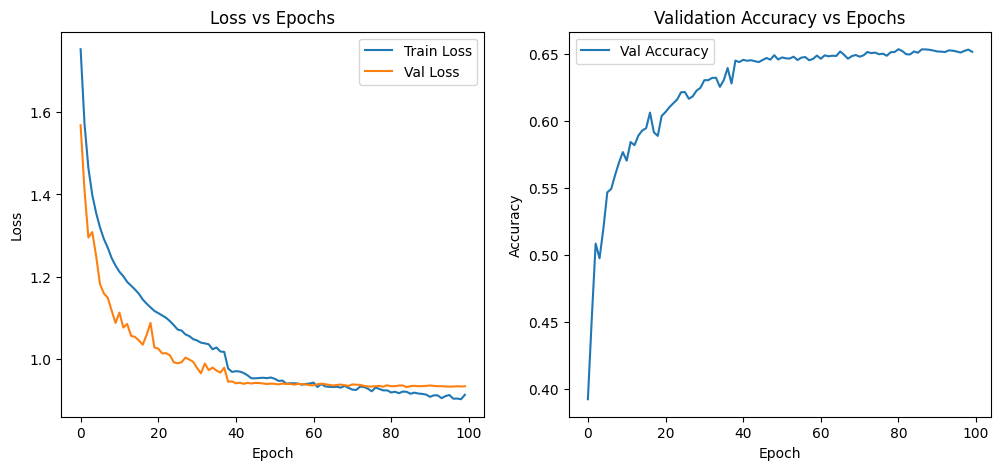

In [68]:
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

save_path = "/content/drive/MyDrive/best_model.pth"

best_val = 0.0

# Lists to store values for plotting
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(epochs):
    # ============= TRAIN =============
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)

    # ============= VALIDATION =============
    model.eval()
    correct, total, val_loss = 0, 0, 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = val_loss / len(test_loader)
    val_losses.append(avg_val_loss)

    val_acc = correct / total
    val_accuracies.append(val_acc)
    scheduler.step(avg_val_loss)

    print(
        f"Epoch [{epoch+1}/{epochs}] "
        f"Train Loss: {avg_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}"
    )

    # ============= SAVE BEST MODEL TO DRIVE ============
    if val_acc > best_val:
        best_val = val_acc
        torch.save(model.state_dict(), save_path)
        print(f"✅ Best model saved to Drive (Val Acc: {best_val:.4f})")

# ============= PLOT LOSS AND ACCURACY ============
plt.figure(figsize=(12,5))

# Loss plot
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()

# Accuracy plot
plt.subplot(1,2,2)
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy vs Epochs')
plt.legend()

plt.show()
